In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from PIL import Image

import os
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True
)

testset = torchvision.datasets.CIFAR10(
    root = './data',
    train = False,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def load_data(filename):
  with open('data/cifar-10-batches-py/'+filename,'rb') as file:
    batch = pickle.load(file, encoding='latin1')
  features = batch['data']
  labels = batch['labels']
  return features, labels

In [ ]:
# Load files
batch1, label1 = load_data('data_batch_1')
batch2, label2 = load_data('data_batch_2')
batch3, label3 = load_data('data_batch_3')
batch4, label4 = load_data('data_batch_4')
batch5, label5 = load_data('data_batch_5')

test, test_label = load_data('test_batch')

In [ ]:
Xtrain = np.concatenate([batch1, batch2, batch3, batch4, batch5],0)
Ytrain = np.concatenate([label1, label2, label3, label4, label5],0)

print(Xtrain.shape)
print(test.shape)

(50000, 3072)
(10000, 3072)


In [ ]:
classes = ['airplane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def photo(batchFile):
  assert batchFile.shape[1] == 3072
  dim = np.sqrt(1024).astype(int)
  r = batchFile[:,0:1024].reshape(batchFile.shape[0],dim,dim,1)
  g = batchFile[:,1024:2048].reshape(batchFile.shape[0],dim,dim,1)
  b = batchFile[:,2048:].reshape(batchFile.shape[0],dim,dim,1)
  pic = np.concatenate([r,g,b],-1)
  return pic

In [ ]:
Xtrain = photo(Xtrain)
Xtest = photo(test)
Ytest = np.array(test_label)

In [ ]:
def plotImage(num, file, label, pred=None):
  plt.rcParams['figure.figsize'] = (4,3)
  plt.imshow(file[num])
  if pred is None:
    plt.title(classes[label[num]])
  else:
    plt.title('True Label: ' + classes[label[num]] + '\nLabel Pred: ' + classes[pred[num]])

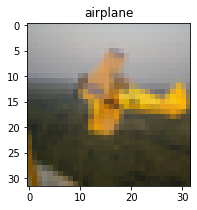

In [ ]:
plotImage(1234,Xtrain,Ytrain)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64


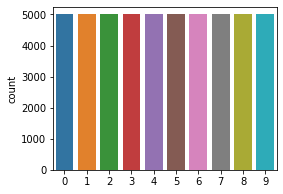

In [ ]:
sns.countplot(Ytrain)
histYtrain = pd.Series(Ytrain).groupby(Ytrain).count()
print(histYtrain)

In [ ]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [ ]:
Xtrain,Xval,Ytrain,Yval = train_test_split(Xtrain, Ytrain,test_size=0.2,random_state=32)

In [ ]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)

(40000, 32, 32, 3)
(40000,)
(10000, 32, 32, 3)
(10000,)


In [ ]:
class CIFAR10(Dataset):

  def __init__(self, data, label, transform=None):

    self.data = data
    self.label = label
    self.transform = transform
    self.imgShape = data.shape
  
  def __getitem__(self,idx):
    img = Image.fromarray(self.data[idx])
    label = self.label[idx]

    if self.transform is not None:
      img = self.transform(img)
    else:
      img = transforms.ToTensor(img)
    return img, label
  
  def __len__(self):
    return len(self.data)
  
  def plotImage(self, number):
    file = self.data
    label = self.label
    plt.rcParams['figure.figsize'] = (4,3)
    plt.imshow(file[number])
    plt.title(classes[label[number]])

In [ ]:
def normalizeDataset(data):
  mean = data.mean(axis=(0,1,2))/255.0
  std = data.std(axis=(0,1,2))/255.0
  normalize = transforms.Normalize(mean=mean, std=std)
  return normalize

In [ ]:
trainTransform = transforms.Compose([
      transforms.Resize((40,40)),
      transforms.RandomCrop((32,32)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(15),
      transforms.ToTensor(),
      normalizeDataset(Xtrain)
])

valTransform = transforms.Compose([
      transforms.ToTensor(),
      normalizeDataset(Xtrain) #Xtrain,Xval should have same distribution
])

testTransform = transforms.Compose([
      transforms.ToTensor(),
      normalizeDataset(Xtest)
])

In [ ]:
trainset = CIFAR10(data=Xtrain,label=Ytrain,transform=trainTransform)
valset = CIFAR10(data=Xval,label=Yval,transform=valTransform)
testset = CIFAR10(data=Xtest,label=Ytest,transform=testTransform)

In [ ]:
print(trainset.imgShape)
print(valset.imgShape)
print(testset.imgShape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
print(len(set(trainset.label)))

10


In [ ]:
BS = 64
num_workers = 1

trainLoader = DataLoader(
    dataset = trainset,
    batch_size = BS,
    shuffle = True,
    num_workers = num_workers
)

valLoader = DataLoader(
    dataset = valset,
    batch_size=BS,
    shuffle = False,
    num_workers = num_workers
)

testLoader = DataLoader(
    dataset = testset,
    batch_size = BS,
    shuffle = False,
    num_workers = num_workers
)

In [ ]:
imgs, lbls = iter(trainLoader).next()
print(imgs.size())
print(imgs.dtype)
print(lbls.size())
print(lbls.dtype)

torch.Size([64, 3, 32, 32])
torch.float32
torch.Size([64])
torch.int64


In [ ]:
class Net1(nn.Module):

  def __init__(self):
    super(Net1,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.fc1 = nn.Linear(in_features=16*5*5,out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self,x):
    out = F.relu(self.conv1(x))
    out = self.pool1(out)
    out = F.relu(self.conv2(out))
    out = self.pool2(out)
    out = out.view(-1,16*5*5)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

print(Net1())

Net1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
class Net2(nn.Module):
  def __init__(self,dropout=0.2):
    super(Net2, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,kernel_size=5, stride=1, padding=2)
    self.dropout1 = nn.Dropout(p=dropout)
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1, padding=1)
    self.dropout2 = nn.Dropout(p=dropout)
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.fc1 = nn.Linear(in_features=8*8*64, out_features=1024)
    self.dropout3 = nn.Dropout(p=dropout)
    self.fc2 = nn.Linear(in_features=1024, out_features=512)
    self.dropout4 = nn.Dropout(p=dropout)
    self.fc3 = nn.Linear(in_features=512, out_features=10)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.dropout1(out)
    out = self.pool1(F.relu(out))
    out = self.conv2(out)
    out = self.dropout2(out)
    out = self.pool2(F.relu(out))
    out = out.view(-1,self.flatFeatures(out))
    out = self.fc1(out)
    out = F.relu(out)
    out = self.dropout3(out)
    out = self.fc2(out)
    out = F.relu(out)
    out = self.dropout4(out)
    out = self.fc3(out)
    return out
  def flatFeatures(self, x):
    size = x.size()[1:]
    featuresNum = 1
    for s in size:
      featuresNum *= s
    return featuresNum

print(Net2(0.2))

Net2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
class Net3(nn.Module):
    
    def __init__(self):
        super(Net3,self).__init__()
        
        self.conv_layer = nn.Sequential(
            
            #Conv layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #Conv layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(p=0.05),
            
            #Conv layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(4096,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512,10)
        )
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layer(x)
        
        return x
print(Net3())

Net3(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
class Net4(nn.Module):
  def __init__(self):
    super(Net4,self).__init__()
    
    self.features = nn.Sequential(
        
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
        
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
        
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
        
        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),    
    )
    self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

  def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


print(Net4())

Net4(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=F

In [ ]:
class Trainer():
  def __init__(self, model, EPOCHS, loss_func, optimizer, trainLoader, valLoader=None, verbose=True):
    self.model = model
    self.EPOCHS = EPOCHS
    self.loss_func = loss_func
    self.optimizer = optimizer
    self.trainLoader = trainLoader
    self.valLoader = valLoader
    self.verbose = verbose

  def printInfo(self,idx, length, epoch_loss, acc, mode):
    if length >= 250:
      updateSize = int(length/250)
    else:
      updateSize = 5
  
    if idx % updateSize == 0 and idx != 0:
      finishRate = idx/length * 100
      print ("\r   {} progress: {:.2f}%  ......  loss: {:.4f} , acc: {:.4f}".
               format(mode, finishRate, epoch_loss/idx, acc), end="", flush=True)

  def valPerEpoch(self):

    self.model.eval()
    epoch_loss = 0.0
    acc = 0.0
    valSize = 0

    with torch.no_grad():
      for i ,(feature, target) in enumerate(self.valLoader):
        if torch.cuda.is_available():
          feature = feature.cuda()
          target = target.cuda()
      
        output = self.model(feature)

        _,pred = torch.max(output.data, dim=1)
        correct = (pred == target).sum().item()
        valSize += target.size(0)
        acc += correct

        loss = self.loss_func(output, target)
        epoch_loss += loss

        if self.verbose:
          self.printInfo(i,len(self.valLoader),epoch_loss,acc/valSize,'validation')
    
      acc = acc/valSize
      print('\n')
      return epoch_loss/len(self.valLoader), acc

  def trainPerEpoch(self):
    self.model.train()

    epoch_loss = 0.0
    acc = 0.0
    trainSize = 0

    for i, (feature,target) in enumerate(self.trainLoader):
      if torch.cuda.is_available():
        feature = feature.cuda()
        target = target.cuda()

        self.optimizer.zero_grad()
        output = self.model(feature)
        loss = self.loss_func(output, target)

        _, pred = torch.max(output.data,dim=1)
        correct = (pred == target).sum().item()
        trainSize  += target.size(0)
        acc += correct

        epoch_loss += loss.item()
        loss.backward()
        self.optimizer.step()

        if self.verbose:
          self.printInfo(i,len(self.trainLoader),epoch_loss,acc/trainSize,"training")

    acc = acc/trainSize
    print('\n')
    return epoch_loss/len(self.trainLoader), acc 

  def fit(self):

    history = {}
    history['train loss'] = []
    history['val loss'] = []
    history['train acc'] = []
    history['val acc'] = []

    numTrainBatches = len(self.trainLoader)

    if self.valLoader is not None:
      numValBatches = len(self.valLoader)
      print('Training on {} samples, validation on {} samples'.format(numTrainBatches*BS, numValBatches*BS))
      print('Training on {} batches, valiadtion on {} batches. {} samples/minibatch\n'.format(numTrainBatches, numValBatches, BS))
    else:
      print('Training on {} samples'.format(numTrainBatches*BS))
      print('Training on {} batches, {} samples/minibatch\n'.format(numTrainBatches, BS))
  
    for epoch in range(self.EPOCHS):
      print('Epoch {}/{}'.format(epoch+1, self.EPOCHS))

      trainLoss, trainAcc = self.trainPerEpoch()
      history['train loss'].append(trainLoss)
      history['train acc'].append(trainAcc)

      if self.valLoader is not None:
        valLoss, valAcc = self.valPerEpoch()

        print('Training Loss: {:.4f}  Validation Loss: {:.4f}'.format(trainLoss, valLoss))
        print('Training Acc: {:.4f}  Validation Acc: {:.4f}\n'.format(trainAcc, valAcc))

        history['val loss'].append(valLoss)
        history['val acc'].append(valAcc)
      else:
        print('Training Loss: {:.4f}\n'.format(trainLoss))
        print('Training Acc: {:.4f}\n'.format(trainAcc))

    return history

  def evaluate(self, dataLoader):
    Ypred = []
    correct = 0
    total = 0
    epoch_loss = 0.0
    acc = 0.0
    testSize = 0

    with torch.no_grad():
      for i, (feature,target) in enumerate(dataLoader):
        if torch.cuda.is_available():
          feature = feature.cuda()
          target = target.cuda()
      
        output = self.model(feature)

        _,pred = torch.max(output.data,dim=1)
        correct = (pred == target).sum().item()
        testSize += target.size(0)
        acc += correct

        loss = self.loss_func(output, target)
        epoch_loss += loss.item()

        if torch.cuda.is_available():
          pred = pred.cuda()
      
        Ypred += pred.cpu().numpy().tolist()

        if self.verbose:
          self.printInfo(i, len(dataLoader), epoch_loss, acc/testSize, "testing")
    
      acc = acc/testSize
      print('\n\n Accuracy on {} test images is {}'.format(testSize, 100*acc))

      return Ypred  

In [ ]:
EPOCHS = 10

net1 = Net1()
net2 = Net2(0.2)
net3 = Net3()
net4 = Net4()
if torch.cuda.is_available():
  net1 = net1.cuda()
  net2 = net2.cuda()
  net3 = net3.cuda()
  net4 = net4.cuda()
print('##################################################')
print(net1)
print('##################################################')
print('\n\n')

print('##################################################')
print(net2)
print('##################################################')
print('\n\n')

print('##################################################')
print(net3)
print('##################################################')
print('\n\n')

print('##################################################')
print(net4)
print('##################################################')
print('\n\n')

loss_func = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(net1.parameters(),lr=0.001)
optimizer2 = torch.optim.Adam(net2.parameters(),lr=0.001)
optimizer3 = torch.optim.Adam(net3.parameters(),lr=0.001)
optimizer4 = torch.optim.Adam(net4.parameters(),lr=0.0001)

##################################################
Net1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
##################################################



##################################################
Net2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (pool2): Max

In [ ]:
trainer1 = Trainer(net1, EPOCHS, loss_func, optimizer1, trainLoader, valLoader, verbose=True)
trainer2 = Trainer(net2, EPOCHS, loss_func, optimizer2, trainLoader, valLoader, verbose=True)
trainer3 = Trainer(net3, EPOCHS, loss_func, optimizer3, trainLoader, valLoader, verbose=True)
trainer4 = Trainer(net4, EPOCHS=50, loss_func=loss_func, optimizer=optimizer4, trainLoader=trainLoader, valLoader=valLoader, verbose=True)

In [ ]:
hist1 = trainer1.fit()

Training on 40000 samples, validation on 10048 samples
Training on 625 batches, valiadtion on 157 batches. 64 samples/minibatch

Epoch 1/10
   training progress: 99.84%  ......  loss: 1.8191 , acc: 0.3283

   validation progress: 98.73%  ......  loss: 1.5880 , acc: 0.4280

Training Loss: 1.8162  Validation Loss: 1.5792
Training Acc: 0.3283  Validation Acc: 0.4280

Epoch 2/10
   training progress: 99.84%  ......  loss: 1.6010 , acc: 0.4119

   validation progress: 98.73%  ......  loss: 1.4866 , acc: 0.4660

Training Loss: 1.5985  Validation Loss: 1.4773
Training Acc: 0.4119  Validation Acc: 0.4660

Epoch 3/10
   training progress: 99.84%  ......  loss: 1.5119 , acc: 0.4473

   validation progress: 98.73%  ......  loss: 1.3962 , acc: 0.5113

Training Loss: 1.5095  Validation Loss: 1.3878
Training Acc: 0.4473  Validation Acc: 0.5112

Epoch 4/10
   training progress: 99.84%  ......  loss: 1.4577 , acc: 0.4717

   validation progress: 98.73%  ......  loss: 1.3533 , acc: 0.5209

Training Los

In [ ]:
Ypred1 = trainer1.evaluate(testLoader)

   testing progress: 98.73%  ......  loss: 1.2316 , acc: 0.5589

 Accuracy on 10000 test images is 55.86


In [ ]:
hist2 = trainer2.fit()

Training on 40000 samples, validation on 10048 samples
Training on 625 batches, valiadtion on 157 batches. 64 samples/minibatch

Epoch 1/10
   training progress: 99.84%  ......  loss: 1.6477 , acc: 0.3969

   validation progress: 98.73%  ......  loss: 1.4545 , acc: 0.4948

Training Loss: 1.6451  Validation Loss: 1.4458
Training Acc: 0.3969  Validation Acc: 0.4947

Epoch 2/10
   training progress: 99.84%  ......  loss: 1.3987 , acc: 0.4960

   validation progress: 98.73%  ......  loss: 1.2846 , acc: 0.5464

Training Loss: 1.3964  Validation Loss: 1.2780
Training Acc: 0.4960  Validation Acc: 0.5460

Epoch 3/10
   training progress: 99.84%  ......  loss: 1.2934 , acc: 0.5410

   validation progress: 98.73%  ......  loss: 1.1815 , acc: 0.5880

Training Loss: 1.2913  Validation Loss: 1.1749
Training Acc: 0.5410  Validation Acc: 0.5878

Epoch 4/10
   training progress: 99.84%  ......  loss: 1.2320 , acc: 0.5620

   validation progress: 98.73%  ......  loss: 1.1358 , acc: 0.6000

Training Los

In [ ]:
Ypred2 = trainer2.evaluate(testLoader)

   testing progress: 98.73%  ......  loss: 1.0127 , acc: 0.6441

 Accuracy on 10000 test images is 64.39


In [ ]:
hist3 = trainer3.fit()

Training on 40000 samples, validation on 10048 samples
Training on 625 batches, valiadtion on 157 batches. 64 samples/minibatch

Epoch 1/10
   training progress: 99.84%  ......  loss: 1.7052 , acc: 0.3605

   validation progress: 98.73%  ......  loss: 1.5637 , acc: 0.4605

Training Loss: 1.7025  Validation Loss: 1.5537
Training Acc: 0.3605  Validation Acc: 0.4606

Epoch 2/10
   training progress: 99.84%  ......  loss: 1.4094 , acc: 0.4856

   validation progress: 98.73%  ......  loss: 1.4982 , acc: 0.5013

Training Loss: 1.4071  Validation Loss: 1.4891
Training Acc: 0.4856  Validation Acc: 0.5011

Epoch 3/10
   training progress: 99.84%  ......  loss: 1.2564 , acc: 0.5450

   validation progress: 98.73%  ......  loss: 1.3118 , acc: 0.5409

Training Loss: 1.2544  Validation Loss: 1.3056
Training Acc: 0.5450  Validation Acc: 0.5404

Epoch 4/10
   training progress: 99.84%  ......  loss: 1.1477 , acc: 0.5884

   validation progress: 98.73%  ......  loss: 1.0234 , acc: 0.6410

Training Los

In [ ]:
Ypred3 = trainer3.evaluate(testLoader)

   testing progress: 98.73%  ......  loss: 0.8884 , acc: 0.7032

 Accuracy on 10000 test images is 70.30999999999999


In [ ]:
hist4 = trainer4.fit()

Training on 40000 samples, validation on 10048 samples
Training on 625 batches, valiadtion on 157 batches. 64 samples/minibatch

Epoch 1/50
   training progress: 99.84%  ......  loss: 1.5772 , acc: 0.4229

   validation progress: 98.73%  ......  loss: 1.5873 , acc: 0.4568

Training Loss: 1.5746  Validation Loss: 1.5787
Training Acc: 0.4229  Validation Acc: 0.4567

Epoch 2/50
   training progress: 99.84%  ......  loss: 1.2160 , acc: 0.5706

   validation progress: 98.73%  ......  loss: 1.2765 , acc: 0.5771

Training Loss: 1.2141  Validation Loss: 1.2702
Training Acc: 0.5706  Validation Acc: 0.5769

Epoch 3/50
   training progress: 99.84%  ......  loss: 1.0489 , acc: 0.6373

   validation progress: 98.73%  ......  loss: 1.0402 , acc: 0.6529

Training Loss: 1.0472  Validation Loss: 1.0348
Training Acc: 0.6373  Validation Acc: 0.6527

Epoch 4/50
   training progress: 99.84%  ......  loss: 0.9399 , acc: 0.6757

   validation progress: 98.73%  ......  loss: 0.9015 , acc: 0.6971

Training Los

In [ ]:
Ypred4 = trainer4.evaluate(testLoader)

   testing progress: 98.73%  ......  loss: 0.5597 , acc: 0.8458

 Accuracy on 10000 test images is 84.58


In [ ]:
def plotLossAcc(history):
  fig, ax = plt.subplots(2,1)
  ax[0].plot(history['train loss'], color='b',label='Training Loss')
  ax[0].plot(history['val loss'], color='r',label='Validation Loss', axes=ax[0])
  legend = ax[0].legend(loc='best',shadow=True)

  ax[1].plot(history['train acc'], color='b',label='Training Acc')
  ax[1].plot(history['val acc'], color='r',label='Validation Acc', axes=ax[1])
  legend = ax[1].legend(loc='best',shadow=True)

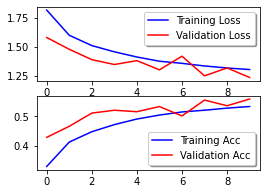

In [ ]:
plotLossAcc(hist1)

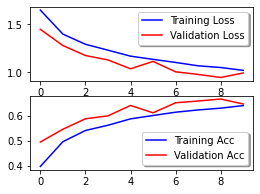

In [ ]:
plotLossAcc(hist2)

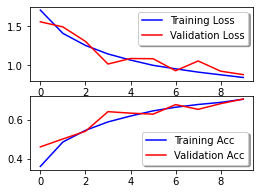

In [ ]:
plotLossAcc(hist3)

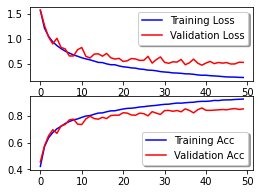

In [ ]:
plotLossAcc(hist4)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Ytest, Ypred1)
print(cm)
print('\n\n')
print(classification_report(Ytest, Ypred1))

[[755  41  33   9  12   8  16  13  70  43]
 [ 77 710   5   6   0   2   9   6  36 149]
 [154  18 358  62  91  89 121  51  22  34]
 [ 46  29  53 257  43 243 145  66  20  98]
 [ 70  17  90  46 352  65 191 117  16  36]
 [ 26  10  49 124  44 494  71 115  14  53]
 [ 19  17  51  47  32  23 730  35  11  35]
 [ 41  12  22  40  63  88  20 652   5  57]
 [214  63   5   7   2   8   8   8 622  63]
 [ 78 171   6   7   6   3  24  18  31 656]]



              precision    recall  f1-score   support

           0       0.51      0.76      0.61      1000
           1       0.65      0.71      0.68      1000
           2       0.53      0.36      0.43      1000
           3       0.42      0.26      0.32      1000
           4       0.55      0.35      0.43      1000
           5       0.48      0.49      0.49      1000
           6       0.55      0.73      0.63      1000
           7       0.60      0.65      0.63      1000
           8       0.73      0.62      0.67      1000
           9       0.54  

In [ ]:
cm = confusion_matrix(Ytest, Ypred2)
print(cm)
print('\n\n')
print(classification_report(Ytest, Ypred2))

[[818  38  16   3  11   0  15  14  48  37]
 [ 40 773   0   2   4   0  18   3  11 149]
 [143  11 340  31 159  50 173  52  20  21]
 [ 58  21  34 320 120 111 182  81  18  55]
 [ 45   5  22  25 659   8 151  60  11  14]
 [ 28  10  27 116 147 429  94 103  11  35]
 [ 23   2  12  26  36   2 881   8   6   4]
 [ 26   6   6  14 106  20  25 754   5  38]
 [165  55   7   7   9   3   7   4 689  54]
 [ 65 116   3   8   3   2   9   8  10 776]]



              precision    recall  f1-score   support

           0       0.58      0.82      0.68      1000
           1       0.75      0.77      0.76      1000
           2       0.73      0.34      0.46      1000
           3       0.58      0.32      0.41      1000
           4       0.53      0.66      0.58      1000
           5       0.69      0.43      0.53      1000
           6       0.57      0.88      0.69      1000
           7       0.69      0.75      0.72      1000
           8       0.83      0.69      0.75      1000
           9       0.66  

In [ ]:
cm = confusion_matrix(Ytest, Ypred3)
print(cm)
print('\n\n')
print(classification_report(Ytest, Ypred3))

[[847  34  22   2  12   1   8   5  59  10]
 [ 18 941   0   0   1   1   2   1  11  25]
 [148  14 491  12  99  49 127  24  19  17]
 [ 59  23  61 289  89 128 178  43  71  59]
 [ 40   4  48  20 667   5 122  65  16  13]
 [ 24   9  34  87  88 545  75  77  32  29]
 [ 19  13  44   7  15   8 872   4  10   8]
 [ 40  10  20   8  77  30  12 759  12  32]
 [ 90  42   3   1   3   1   6   1 838  15]
 [ 65 117   2   1   1   0   0   7  25 782]]



              precision    recall  f1-score   support

           0       0.63      0.85      0.72      1000
           1       0.78      0.94      0.85      1000
           2       0.68      0.49      0.57      1000
           3       0.68      0.29      0.41      1000
           4       0.63      0.67      0.65      1000
           5       0.71      0.55      0.62      1000
           6       0.62      0.87      0.73      1000
           7       0.77      0.76      0.76      1000
           8       0.77      0.84      0.80      1000
           9       0.79  

In [ ]:
cm = confusion_matrix(Ytest, Ypred3)
print(cm)
print('\n\n')
print(classification_report(Ytest, Ypred4))

[[847  34  22   2  12   1   8   5  59  10]
 [ 18 941   0   0   1   1   2   1  11  25]
 [148  14 491  12  99  49 127  24  19  17]
 [ 59  23  61 289  89 128 178  43  71  59]
 [ 40   4  48  20 667   5 122  65  16  13]
 [ 24   9  34  87  88 545  75  77  32  29]
 [ 19  13  44   7  15   8 872   4  10   8]
 [ 40  10  20   8  77  30  12 759  12  32]
 [ 90  42   3   1   3   1   6   1 838  15]
 [ 65 117   2   1   1   0   0   7  25 782]]



              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1000
           1       0.84      0.96      0.90      1000
           2       0.79      0.83      0.81      1000
           3       0.73      0.74      0.73      1000
           4       0.88      0.78      0.83      1000
           5       0.92      0.68      0.78      1000
           6       0.88      0.89      0.89      1000
           7       0.84      0.92      0.88      1000
           8       0.94      0.87      0.90      1000
           9       0.84  

In [ ]:
for i in range(len(classes)):
    correct = ((Ytest == i)*1) * ((np.array(Ypred1) == Ytest)*1)
    print('{}, {}: '.rjust(10).format(i, classes[i]) + '{}%'.
          format(100*correct.sum()/Ytest[Ytest == i].shape[0]))

  0, airplane: 66.8%
  1, car: 74.3%
  2, bird: 24.1%
  3, cat: 24.4%
  4, deer: 34.6%
  5, dog: 38.7%
  6, frog: 73.7%
  7, horse: 55.9%
  8, ship: 60.5%
  9, truck: 78.0%


In [ ]:
for i in range(len(classes)):
    correct = ((Ytest == i)*1) * ((np.array(Ypred2) == Ytest)*1)
    print('{}, {}: '.rjust(10).format(i, classes[i]) + '{}%'.
          format(100*correct.sum()/Ytest[Ytest == i].shape[0]))

  0, airplane: 82.8%
  1, car: 86.7%
  2, bird: 35.9%
  3, cat: 42.2%
  4, deer: 59.9%
  5, dog: 48.9%
  6, frog: 84.3%
  7, horse: 71.7%
  8, ship: 82.2%
  9, truck: 67.8%


In [ ]:
for i in range(len(classes)):
    correct = ((Ytest == i)*1) * ((np.array(Ypred3) == Ytest)*1)
    print('{}, {}: '.rjust(10).format(i, classes[i]) + '{}%'.
          format(100*correct.sum()/Ytest[Ytest == i].shape[0]))

  0, airplane: 79.8%
  1, car: 88.6%
  2, bird: 32.8%
  3, cat: 21.5%
  4, deer: 29.6%
  5, dog: 37.0%
  6, frog: 85.9%
  7, horse: 67.4%
  8, ship: 83.3%
  9, truck: 84.3%


In [ ]:
for i in range(len(classes)):
    correct = ((Ytest == i)*1) * ((np.array(Ypred4) == Ytest)*1)
    print('{}, {}: '.rjust(10).format(i, classes[i]) + '{}%'.
          format(100*correct.sum()/Ytest[Ytest == i].shape[0]))

  0, airplane: 88.5%
  1, car: 96.0%
  2, bird: 83.3%
  3, cat: 73.6%
  4, deer: 78.2%
  5, dog: 67.5%
  6, frog: 89.1%
  7, horse: 92.2%
  8, ship: 87.4%
  9, truck: 90.0%


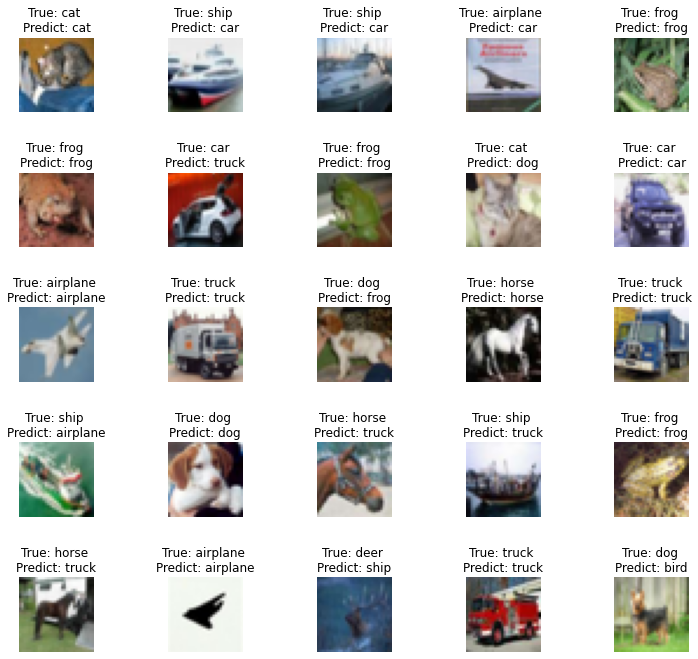

In [ ]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(Xtest[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[Ytest[i]], classes[Ypred1[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

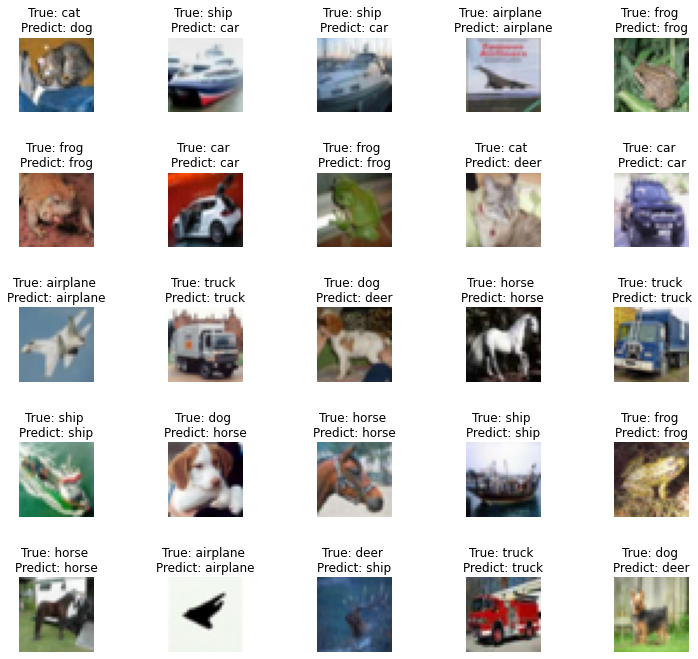

In [ ]:
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(Xtest[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[Ytest[i]], classes[Ypred2[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

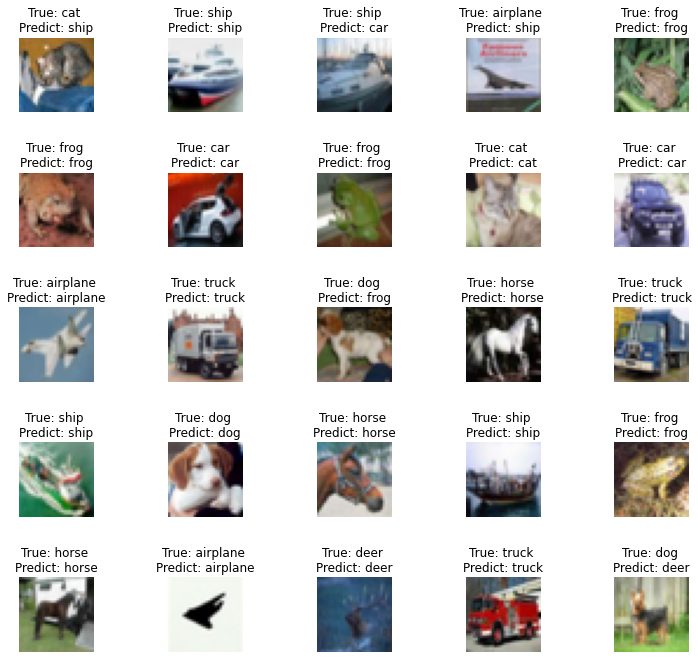

In [ ]:
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(Xtest[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[Ytest[i]], classes[Ypred3[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

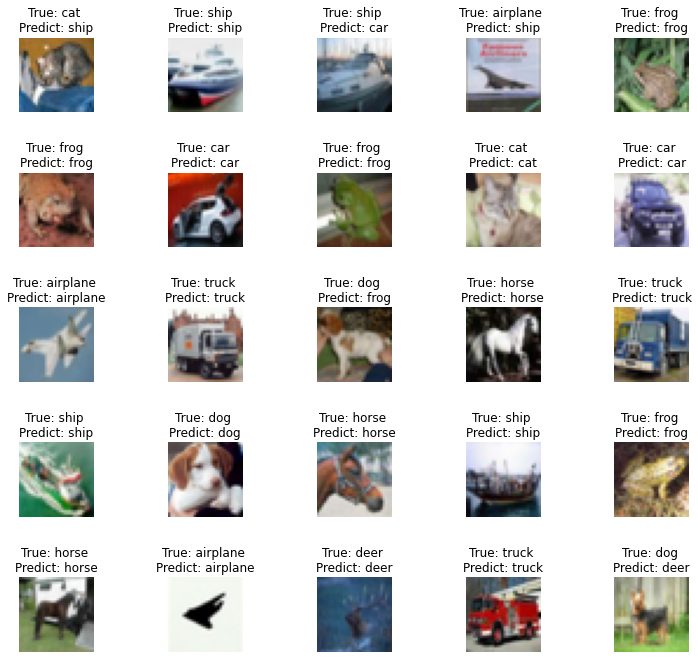

In [ ]:
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(Xtest[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[Ytest[i]], classes[Ypred3[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)